## Image Colorization Using Convolution GAN - Network Architecture 2

## Importing Required Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np

from matplotlib import image
from matplotlib import pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split

## Data Preparation

In [3]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Define parameters
img_size = 32
batch_size = 32
dataset_split = len(x_train)  # Split the entire dataset

# Preprocess the CIFAR-10 dataset
x = []
y = []
for i in range(dataset_split):
    rgb_image = Image.fromarray(x_train[i]).resize((img_size, img_size))
    rgb_img_array = np.asarray(rgb_image) / 255.0
    gray_image = rgb_image.convert('L')
    gray_img_array = np.asarray(gray_image).reshape((img_size, img_size, 1)) / 255.0
    x.append(gray_img_array)
    y.append(rgb_img_array)

# Train-test splitting
X_train, X_test, y_train, y_test = train_test_split(np.array(x), np.array(y), test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(np.array(X_test), np.array(y_test), test_size=0.5)

print("X train:",X_train.shape)
print("y train:",y_train.shape)
print("X val:",X_val.shape)
print("y val:",y_val.shape)
print("X test:",X_test.shape)
print("y test:",y_test.shape)


# Construct tf.data.Dataset object
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size)

170498071/170498071 [==============================] - 2s 0us/step
X train: (35000, 32, 32, 1)
y train: (35000, 32, 32, 3)
X val: (7500, 32, 32, 1)
y val: (7500, 32, 32, 3)
X test: (7500, 32, 32, 1)
y test: (7500, 32, 32, 3)


## GAN Model Definition

In [4]:
def generator_model():

    inputs = tf.keras.layers.Input( shape=( img_size , img_size , 1 ) )

    conv1 = tf.keras.layers.Conv2D( 16 , kernel_size=( 5 , 5 ) , strides=1 )( inputs )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )
    conv1 = tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1)( conv1 )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )
    conv1 = tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1)( conv1 )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )

    conv2 = tf.keras.layers.Conv2D( 32 , kernel_size=( 5 , 5 ) , strides=1)( conv1 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )
    conv2 = tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 )( conv2 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )
    conv2 = tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 )( conv2 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )

    conv3 = tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1 )( conv2 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )
    conv3 = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 )( conv3 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )
    conv3 = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 )( conv3 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )

    bottleneck = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='tanh' , padding='same' )( conv3 )

    concat_1 = tf.keras.layers.Concatenate()( [ bottleneck , conv3 ] )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_1 )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( conv_up_3 )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' )( conv_up_3 )

    concat_2 = tf.keras.layers.Concatenate()( [ conv_up_3 , conv2 ] )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_2 )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( conv_up_2 )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' )( conv_up_2 )

    concat_3 = tf.keras.layers.Concatenate()( [ conv_up_2 , conv1 ] )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu')( concat_3 )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu')( conv_up_1 )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 3 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu')( conv_up_1 )

    model = tf.keras.models.Model( inputs , conv_up_1 )
    return model


In [5]:
def discriminator_model():
    layers = [
        tf.keras.layers.Conv2D( 16 , kernel_size=( 5 , 5 ) , strides=1, padding='same', activation='relu' , input_shape=( 32 , 32 , 3 ) ),
        tf.keras.layers.Conv2D( 32 , kernel_size=( 5, 5 ) , strides=1, padding='same',activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, padding='same', activation='relu'  ),
        tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, padding='same', activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1, padding='same', activation='relu'  ),
        tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1, padding='same',activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1, padding='same',activation='relu'  ),
        tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1, padding='same',activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense( 512, activation='relu'  )  ,
        tf.keras.layers.Dense( 128 , activation='relu' ) ,
        tf.keras.layers.Dense( 16 , activation='relu' ) ,
        tf.keras.layers.Dense( 1 , activation='sigmoid' )
    ]
    model = tf.keras.models.Sequential( layers )
    return model

# def discriminator_model():
#     layers = [
#         tf.keras.layers.Conv2D(16, kernel_size=(5, 5), strides=1, padding='same', activation='relu', input_shape=(32, 32, 3)),
#         tf.keras.layers.Conv2D(32, kernel_size=(5, 5), strides=2, padding='same', activation='relu'),
#         tf.keras.layers.Conv2D(64, kernel_size=(5, 5), strides=2, padding='same', activation='relu'),
#         tf.keras.layers.Conv2D(128, kernel_size=(5, 5), strides=2, padding='same', activation='relu'),
#         tf.keras.layers.Flatten(),
#         tf.keras.layers.Dense(256, activation='relu'),
#         tf.keras.layers.Dense(1, activation='sigmoid')
#     ]
#     model = tf.keras.models.Sequential(layers)
#     return model



## Defining Loss

In [16]:
generator = generator_model()
discriminator = discriminator_model()

# Defining Loss functions and mse
cross_entropy = tf.keras.losses.BinaryCrossentropy()
mse = tf.keras.losses.MeanSquaredError()

# Defining generator and discriminator optimizer
generator_optimizer = tf.keras.optimizers.Adam( 0.0005 )
discriminator_optimizer = tf.keras.optimizers.Adam( 0.0005 )

# Defining generator and discriminator loss
def discriminator_loss(real_img, fake_img):
    real_loss = cross_entropy(tf.ones_like(real_img) - tf.random.uniform( shape=real_img.shape , maxval=0.1 ) , real_img)
    fake_loss = cross_entropy(tf.zeros_like(fake_img) + tf.random.uniform( shape=fake_img.shape , maxval=0.1  ) , fake_img)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_img , real_y):
    real_y = tf.cast( real_y , 'float32' )
    return mse( fake_img , real_y )


## Training the model

In [17]:
num_epochs = 50
t_gen_loss = []
t_disc_loss = []
# t_accuracy = []

v_gen_loss = []
v_disc_loss = []
# v_accuracy = []

# accuracy = tf.keras.metrics.BinaryAccuracy()

for each_epoch in range(1, num_epochs+1):
    print("Epoch:", each_epoch, "/", num_epochs)

    # Reset the metrics
    # accuracy.reset_states()

    # Training loop
    for (x_input, y_real) in train_dataset:
        # train_step(x_input, y_real)
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # Generate an image
            generated_images = generator(x_input, training=True)

            real_output = discriminator(y_real, training=True)
            generated_output = discriminator(generated_images, training=True)

            # L2 Loss
            gen_loss = generator_loss(generated_images, y_real)

            # Log loss for the discriminator
            disc_loss = discriminator_loss(real_output, generated_output)

        # Compute the gradients
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        # Optimize with Adam
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        # # Update accuracy metric on CPU
        # with tf.device('/CPU:0'):
        #     accuracy.update_state(tf.squeeze(y_real), tf.squeeze(generated_images))

    # Print generator loss, discriminator loss, and training accuracy
    t_gen_loss.append(gen_loss.numpy())
    t_disc_loss.append(disc_loss.numpy())
    # t_accuracy.append(accuracy.result().numpy())

    print('Training - Generator loss:', gen_loss.numpy(), 'Discriminator loss:', disc_loss.numpy())

    # return gen_loss.numpy(),disc_loss.numpy(),accuracy.result().numpy()
    # Validation loop
    # accuracy.reset_states()
    total_val_gen_loss = 0.0
    total_val_disc_loss = 0.0
    num_val_batches = 0

    for (val_x_input, val_y_real) in val_dataset:
        generated_val_images = generator(val_x_input, training=False)
        val_real_output = discriminator(val_y_real, training=False)
        val_generated_output = discriminator(generated_val_images, training=False)

        val_gen_loss = generator_loss(generated_val_images, val_y_real)
        val_disc_loss = discriminator_loss(val_real_output, val_generated_output)

        total_val_gen_loss += val_gen_loss.numpy()
        total_val_disc_loss += val_disc_loss.numpy()
        num_val_batches += 1

        # # Update accuracy metric on CPU
        # with tf.device('/CPU:0'):
        #     accuracy.update_state(tf.squeeze(val_y_real), tf.squeeze(generated_val_images))

    v_gen_loss.append(total_val_gen_loss / num_val_batches)
    v_disc_loss.append(total_val_disc_loss / num_val_batches)
    # v_accuracy.append(accuracy.result().numpy())

    print('Validation - Generator loss:', total_val_gen_loss / num_val_batches, 'Discriminator loss:', total_val_disc_loss / num_val_batches)


Epoch: 1 / 50
Training - Generator loss: 0.00944301 Discriminator loss: 0.40936387
Validation - Generator loss: 0.007789274267455999 Discriminator loss: 0.4193618840359627
Epoch: 2 / 50
Training - Generator loss: 0.008783165 Discriminator loss: 0.4128043
Validation - Generator loss: 0.006975069592528521 Discriminator loss: 0.41197196384693713
Epoch: 3 / 50
Training - Generator loss: 0.008417128 Discriminator loss: 0.4105218
Validation - Generator loss: 0.006693355264538463 Discriminator loss: 0.5109121828637224
Epoch: 4 / 50
Training - Generator loss: 0.00823066 Discriminator loss: 0.39912507
Validation - Generator loss: 0.006449931169404312 Discriminator loss: 0.41767077268438135
Epoch: 5 / 50
Training - Generator loss: 0.007976937 Discriminator loss: 0.4219334
Validation - Generator loss: 0.006302613769955141 Discriminator loss: 0.4193700300886276
Epoch: 6 / 50
Training - Generator loss: 0.00769397 Discriminator loss: 0.4061789
Validation - Generator loss: 0.006173519486997356 Discri

## Testing

In [18]:
y = generator( X_test[0 : ] ).numpy()

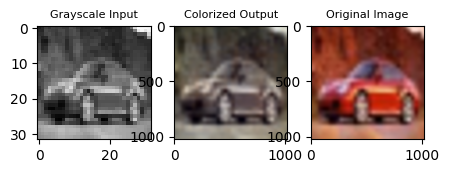

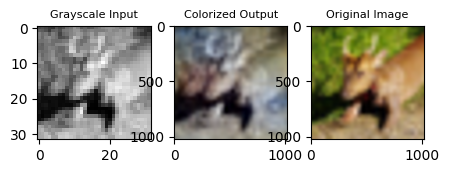

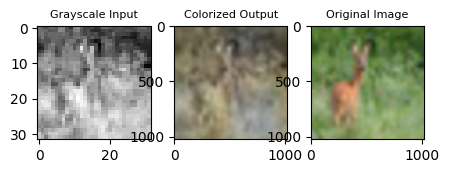

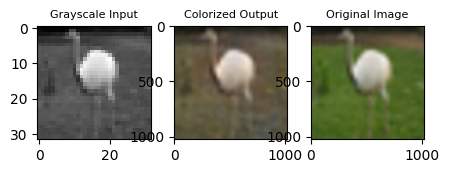

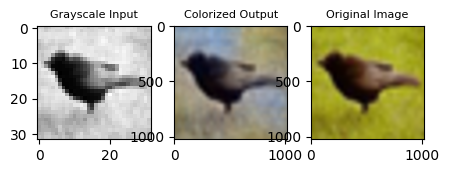

In [19]:
# for i in range(len(X_test)):
for i in range(5):
  plt.figure(figsize=(5,5))
  or_image = plt.subplot(3,3,1)
  or_image.set_title('Grayscale Input', fontsize=8)
  plt.imshow( X_test[i].reshape((32,32)) , cmap='gray' )

  in_image = plt.subplot(3,3,2)
  image = Image.fromarray( ( y[i] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  image = np.asarray( image )
  in_image.set_title('Colorized Output', fontsize=8)
  plt.imshow( image )

  ou_image = plt.subplot(3,3,3)
  image = Image.fromarray( ( y_test[i] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  ou_image.set_title('Original Image', fontsize=8)
  plt.imshow( image )

  plt.show()

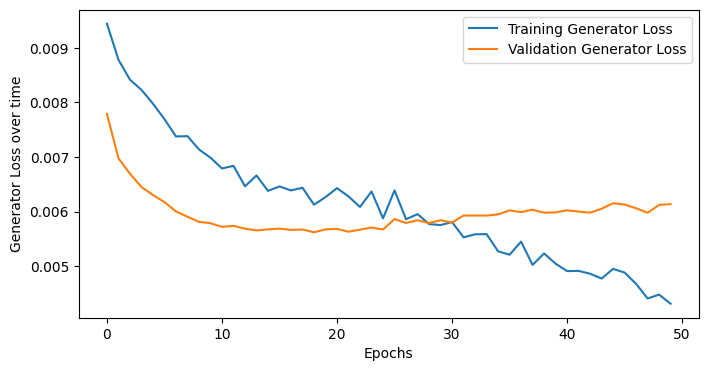

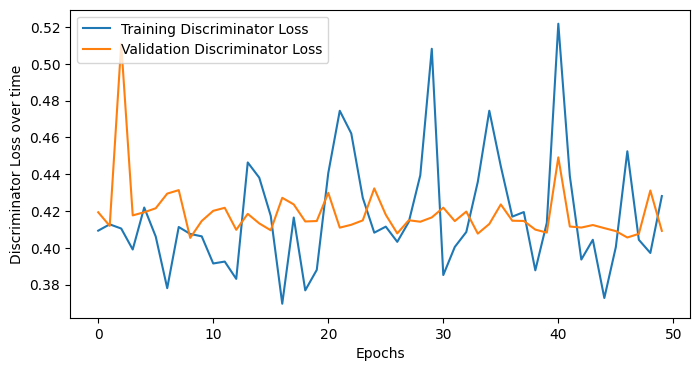

In [20]:
import matplotlib.pyplot as plt

# Plot the loss
plt.figure(figsize=(8, 4))
plt.plot(t_gen_loss, label='Training Generator Loss')
plt.plot(v_gen_loss, label='Validation Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Generator Loss over time')
plt.legend()
plt.show()

# Plot the accuracy
plt.figure(figsize=(8, 4))
plt.plot(t_disc_loss, label='Training Discriminator Loss')
plt.plot(v_disc_loss, label='Validation Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Discriminator Loss over time')
plt.legend()
plt.show()

# # Plot the accuracy
# plt.figure(figsize=(8, 4))
# plt.plot(t_accuracy, label='Training Accuracy')
# plt.plot(v_accuracy, label='Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy over time')
# plt.legend()
# plt.show()

